In [1]:
from Layers import *
from Network import *
from Task import *

In [12]:
import pickle
with open('TraceTask.pkl', 'rb') as input:
    TraceTask = pickle.load(input)

In [8]:

import pandas as pd
df = pd.read_pickle("NetworksTrace.pkl")

In [10]:
def RunTrials(t,CurveLength,TrialNumber,n,device,dataset,index):
    n.exploit_prob = 1
    n.dotrain = False
    n.dosave = True
    corrects = []
    target_history = []
    distr_history = []
    feature_history = []
    display = []
    t.curve_length = CurveLength
    t.feature_target = 0
    action = np.zeros((1,49));
    action[0] = 1;
    n.saveX = [[]]
    n.saveXmod = [[]]
    n.saveY1 = [[]]
    n.saveY1mod = [[]]
    n.saveY2 = [[]]
    n.saveQ = [[]]
    for p in range(TrialNumber):
      trial_running = True
      display.append([])
      feature_history.append(t.feature_target) 
      i=0
      new_input, reward, trialEnd= t.doStep(action,dataset,index)
      while trial_running:
        action = n.doStep(new_input,reward,trialEnd,device)
        new_input, reward, trialEnd = t.doStep(action,dataset,index)
        display[p].append(n.X.detach())
        if trialEnd:
          trial_running = False
          if reward == 0:
            corrects.append(0)
          else:
            corrects.append(1)
        i = i + 1
      target_history.append(t.trialTarget)
      distr_history.append(t.trialDistr) 
    print(np.mean(corrects))
    return(n,corrects,feature_history,target_history,distr_history,display)  




In [71]:
Corrects = []
TargetHist = []
DistrHist = []
SaveXmod = []
device = None
dur = 15
CurveLength = 6
grid_size = 20
TrialNumber = 100
valid_index = list(np.arange(3000))
for k in range(1):
        n = df['Network'][k]
        t = Task(4, 'trace')
        t.onestep = True
        t.onlyblue = False
        n,corrects,feature_history,target_history,distr_history,display = RunTrials(t,CurveLength,TrialNumber,n,device,TraceTask[str(CurveLength)],valid_index)
        Corrects.append(corrects)
        TargetHist.append(target_history)
        DistrHist.append(distr_history)
        curves = [np.zeros((TrialNumber,dur)) for i in range(CurveLength)]
        ar = n.saveXmod
        for p in range(1,TrialNumber):
            if len(ar[p]) > dur:
                if corrects[p-1] == 1:
                    target_hist = target_history[p-1].copy()
                    distr_hist = distr_history[p-1].copy()
                    curvestemp = [np.zeros((dur)) for i in range(CurveLength)]
                for i in range(dur):
                    curvestemp[0][i] = ar[p][i][0,0,target_hist[0] % grid_size, target_hist[0] //grid_size] - ar[p][i][0,0,distr_hist[0]%grid_size,distr_hist[0]//grid_size]
                    for l in range(1,CurveLength-1):
                        curvestemp[l][i] = ar[p][i][0,2,target_hist[l]%grid_size,target_hist[l]//grid_size] -  ar[p][i][0,2,distr_hist[l]%grid_size,distr_hist[l]//grid_size]
                    curvestemp[CurveLength-1][i] = ar[p][i][0,3,target_hist[CurveLength-1]%grid_size,target_hist[CurveLength-1]//grid_size] -  ar[p][i][0,3,distr_hist[CurveLength-1]%grid_size,distr_hist[CurveLength-1]//grid_size]
                for l in range(CurveLength):
                    curves[l][p,:] = curvestemp[l]
        for l in range(CurveLength):
            curves[l] = curves[l][~np.all(curves[l] == 0, axis=1)]
        SaveXmod.append(curves)  

/users/bp000418/Network.py:143: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  winner = [torch.tensor([0]), torch.tensor([0]), torch.tensor([(winner-2)%self.grid_size]), torch.tensor([(winner-2) // self.grid_size])]


1.0


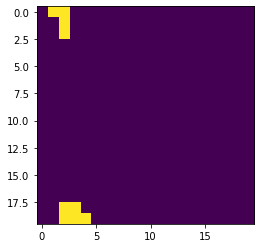

In [73]:
plt.imshow(n.saveX[2][-1][0,2,:,:])

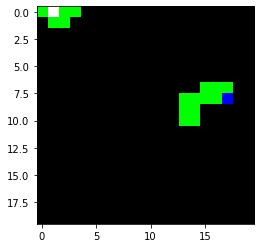

In [64]:
plt.imshow(n.saveX[1][-1][0,[0,2,3],:,:].permute(1,2,0))

<Figure size 432x720 with 0 Axes>

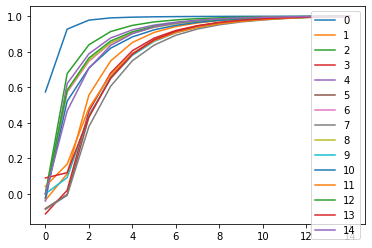

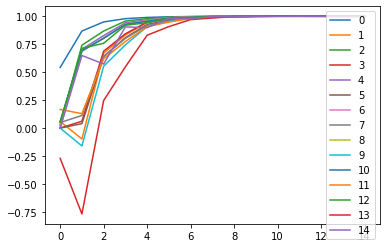

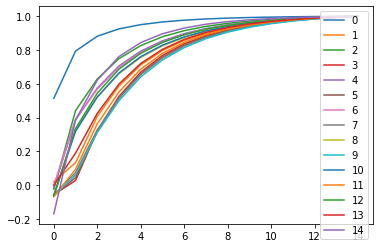

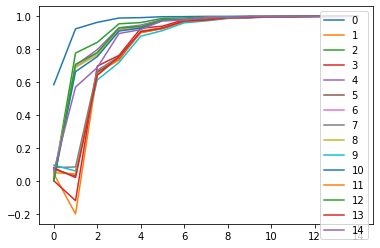

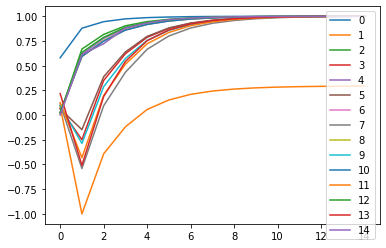

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,10))
for p in range(5):
    plt.figure()
    for l in range(CurveLength):
        plt.plot(np.mean(SaveXmod[p][l],axis=0)/np.max(np.abs(np.mean(SaveXmod[p][l],axis=0))))    
    plt.legend([str(i) for i in range(CurveLength)])

In [21]:
df2.to_pickle("ResultsTraceNeuron.pkl")

In [46]:
delays = np.zeros((70,5))
xx = np.linspace(0, 40, num=600)
for k in range(70):
    interpollated_curves = []   
    mean_normalized_curves = [np.mean(SaveXmod[k][l],axis=0)/np.max(np.abs(np.mean(SaveXmod[k][l],axis=0))) for l in range(6)]
    for i in range(6):
        interp = np.interp(xx, np.arange(0,40), mean_normalized_curves[i])
        interpollated_curves.append(interp)

    Y = []
    for i in range(1,6):
        if np.max(interpollated_curves[i])>=0.1:
            Y.append(xx[np.min(np.argwhere(interpollated_curves[i]>=0.1))])
        else:
            Y.append(np.nan)
    delays[k,:] = Y

In [49]:
from scipy import stats
stats.ttest_ind(delays[:,3],delays[:,4],nan_policy='omit')

Ttest_indResult(statistic=-4.136999915867452, pvalue=6.201890555275004e-05)

In [47]:
np.nanmean(delays,axis=0)

array([4.1836394 , 3.69891849, 6.70683022, 6.18712347, 9.01907219])

In [32]:
delays

array([[10.15025042, 11.75292154, 14.89148581, 14.49081803,  6.5442404 ],
       [13.15525876, 11.95325543, 15.62604341, 15.62604341, 10.5509182 ],
       [10.5509182 ,  9.54924875, 12.62103506, 12.35392321, 16.02671119],
       [16.29382304, 15.95993322, 20.50083472, 20.9015025 , 12.48747913],
       [16.16026711, 16.49415693, 20.43405676, 19.49916528, 13.15525876],
       [ 5.8096828 ,  6.21035058,  8.61435726,  8.21368948, 10.28380634],
       [ 8.14691152,  7.74624374, 10.28380634,  9.28213689,         nan],
       [ 8.01335559,  9.61602671, 15.22537563, 16.42737896, 16.96160267],
       [ 9.54924875, 11.95325543, 15.8263773 , 15.95993322, 17.36227045],
       [ 9.8163606 , 13.15525876, 17.16193656, 17.69616027, 13.42237062],
       [ 5.47579299,  5.07512521,  7.67946578,  7.67946578,  9.14858097],
       [12.95492487, 14.15692821, 18.3639399 , 17.6293823 , 18.63105175],
       [10.61769616, 12.22036728, 16.22704508, 15.15859766, 15.55926544],
       [14.89148581, 14.29048414, 19.3